In [1]:
from straight_30_hz import downselected
import matplotlib.pyplot as plt
import os
import csv
import numpy as np
import math
import torch
import gpytorch
from scipy.stats import norm
import random

In [2]:

directory = "C:\\Users\\ssathe\\VSCode-Projects\\Nigel_Dataset_Processing\\AutoDRIVE-Nigel-Dataset-main\\straight_30_hz\\downselected"
def process_data(directory, dt):
    trajectories = []
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        
        # checking if it is a file
        # f = filename
        # print(f)
        if os.path.isfile(f):
            #print(f)
            with open(f, newline='') as csvfile:
                filereader = csv.reader(csvfile, delimiter=',', quotechar='|')
                tr = []
                for row in filereader:
                    throttle = float(row[1])
                    x = float(row[5])
                    v = float(row[11])
                    ax = float(row[12])
                    tr.append([throttle, x, v, ax])
                tr = np.array(tr)
        trajectories.append(tr)
    dataset = []
    for trajectory in trajectories:
        v = trajectory[:,2].reshape((-1,1))
        u = trajectory[:,0].reshape((-1,1))
        vdot = ((np.diff(v, axis = 0))/(dt)).reshape((-1,1))
        c = np.hstack((v[:-1,:], u[:-1,:], v[1:,:]))
        # v = trajectory[:-1,1].reshape((-1,1))
        # u = trajectory[:-1,0].reshape((-1,1))
        # v1 = trajectory[1:,1].reshape((-1,1))
        # c = np.hstack((v, u, v1))
        dataset.append(c)
    i = 0
    while i < len(dataset):
        if i==0:
            data = dataset[i]
        else:
            data = np.vstack((data, dataset[i]))
        i+=1
    data.shape
    return data


data = process_data(directory=directory, dt=1/30)

In [4]:
def generate_initial_dataset(data, Ni, set_seed):
    Ni = 10
    random.seed(set_seed)
    samples = random.sample(range(15334), Ni)
    miniset = data[samples,:]
    return miniset

miniset = generate_initial_dataset(data=data, Ni = 10, set_seed=1)


In [5]:
X_train = torch.from_numpy(miniset[:,0:2])
Y_train = torch.from_numpy(miniset[:,2:3])
X_train.shape, Y_train.shape

(torch.Size([10, 2]), torch.Size([10, 1]))

In [6]:
# Train Initial Model:
n_tasks = 1
class BatchIndependentMultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([n_tasks]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([n_tasks])),
            batch_shape=torch.Size([n_tasks])
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal.from_batch_mvn(
            gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        )

def train_model(model):
  smoke_test = ('CI' in os.environ)
  training_iterations = 2 if smoke_test else 120

  # Find optimal model hyperparameters
  model.train()
  likelihood.train()

  # Use the adam optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

  # "Loss" for GPs - the marginal log likelihood
  mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

  for i in range(training_iterations):
      optimizer.zero_grad()
      model = model.double()
      output = model(X_train.double())
      loss = -mll(output, Y_train)
      loss.backward()
      # print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
      optimizer.step()
  return model

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=n_tasks)
model = BatchIndependentMultitaskGPModel(X_train, Y_train, likelihood)
model = train_model(model)

In [7]:
test_data = data
X_test = torch.from_numpy(test_data[:,0:2])
Y_test = torch.from_numpy(test_data[:,2:3])
X_test.shape, Y_test.shape

(torch.Size([15334, 2]), torch.Size([15334, 1]))

In [8]:
# Get into evaluation (predictive posterior) mode
def model_predict(model, X):
    model.eval()
    likelihood.eval()

    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        predictions = likelihood(model(X))
        y_pred = predictions.mean
        lower, upper = predictions.confidence_region()
    
    return y_pred, lower, upper

y_pred, lower, upper = model_predict(model, X_test)

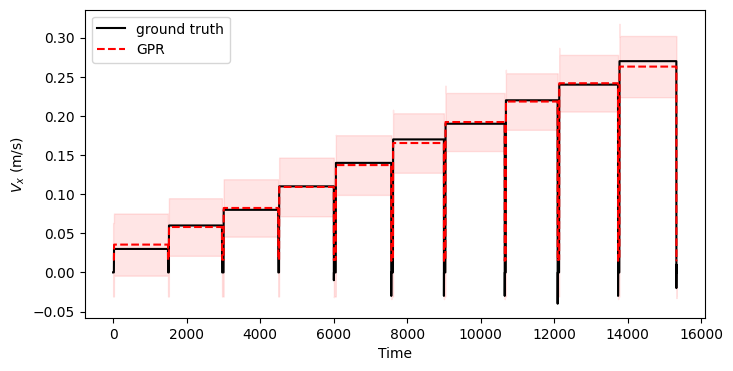

In [9]:

plt.figure(figsize=(8,4))
plt.plot(test_data[:,2],label='ground truth',color='k')

x_plot = np.linspace(0, len(y_pred), len(y_pred))
plt.plot(y_pred.numpy(), color = 'red', label = 'GPR', linestyle = '--')
plt.fill_between(x_plot,lower.numpy()[:,0], upper.numpy()[:,0], alpha = 0.1, color = 'red')
plt.legend()
plt.xlabel('Time')
plt.ylabel('$V_x$ (m/s)')
plt.show()

In [10]:
def upper_confidence_bound(y_pred, lower, upper, lbda):
    ucb = y_pred.numpy()[:,0] + lbda*(upper.numpy()[:,0] - lower.numpy()[:,0])/2
    j = np.argmax(ucb, axis=0)
    return j, ucb

def rmse(y_pred, test_data=test_data[:,2]):
    err = np.sqrt(((y_pred.numpy()- test_data)**2).mean())
    return err

RMSE_no_AL = rmse(y_pred=y_pred, test_data=test_data[:,2])
print(RMSE_no_AL)

0.11046719583809604


## Upper Confidence Bound Acquisition Function

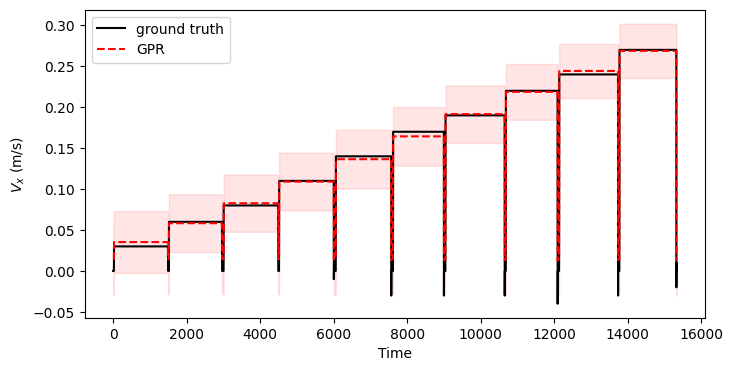

In [11]:
# set how many loops to train
n_loops = 10
lbda = 0.8

x_train = miniset[:,0:2]
y_train = miniset[:,2:3]

x_plot = np.linspace(0, len(y_pred), len(y_pred))
x_acq = []
y_acq = []

for i in range(n_loops):

    j, ucb = upper_confidence_bound(y_pred, lower, upper, lbda = lbda)
    
    x_new = X_test[j,:].numpy().reshape((1,-1))
    y_new = Y_test[j,:].numpy().reshape((1,-1))
    x_acq.append(x_plot[j]) 
    y_acq.append(y_new[0,0])

    x_train = np.vstack((x_train, x_new))
    y_train = np.vstack((y_train, y_new))
    X_train = torch.from_numpy(x_train)
    Y_train = torch.from_numpy(y_train)

    # Retrain Model
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=n_tasks)
    model = BatchIndependentMultitaskGPModel(X_train, Y_train, likelihood)
    model = train_model(model)

    # Evaluate Model
    y_pred, lower, upper = model_predict(model, X_test)



plt.figure(figsize=(8,4))
plt.plot(test_data[:,2],label='ground truth',color='k')

plt.plot(y_pred.numpy(), color = 'red', label = 'GPR', linestyle = '--')
plt.fill_between(x_plot,lower.numpy()[:,0], upper.numpy()[:,0], alpha = 0.1, color = 'red')
plt.legend()
plt.xlabel('Time')
plt.ylabel('$V_x$ (m/s)')
plt.show()

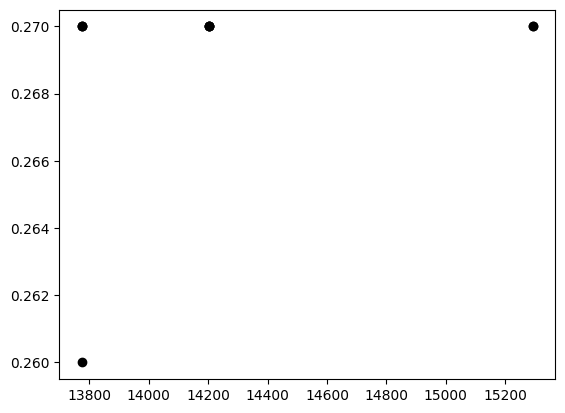

In [12]:
plt.figure()
plt.scatter(np.array(x_acq), np.array(y_acq), color="k")

In [13]:
RMSE_UCB = rmse(y_pred=y_pred, test_data=test_data[:,2])
print(RMSE_UCB)

0.1113203120662704


## Probability of Improvement Acquisition Function

In [14]:
def POI(y_pred,lower,upper,epsilon):
    y_best = y_pred.numpy().max()
    PI = np.empty(y_pred.numpy().size,dtype=float)
    sigma = (upper.numpy()[:,0] - lower.numpy()[:,0])/2
    for i in range(0,y_pred.numpy().size):
        if sigma[i] > 1e-4:
            zz = (y_pred.numpy()[i,0]-y_best-epsilon)/sigma[i]
            PI[i] = norm.cdf(zz)
        else:
            PI[i] = 0.0
    loc = PI.argmax()
    return PI, loc

### Reinitialize and Retrain Model

In [15]:
miniset = generate_initial_dataset(data=data, Ni = 10, set_seed=1)
X_train = torch.from_numpy(miniset[:,0:2])
Y_train = torch.from_numpy(miniset[:,2:3])
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=n_tasks)
model = BatchIndependentMultitaskGPModel(X_train, Y_train, likelihood)
model = train_model(model)
y_pred, lower, upper = model_predict(model, X_test)

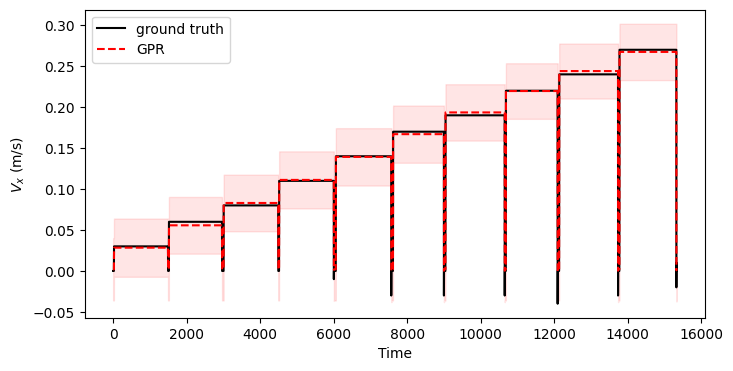

In [16]:
# set how many loops to train
n_loops = 10

x_train = miniset[:,0:2]
y_train = miniset[:,2:3]

x_plot = np.linspace(0, len(y_pred), len(y_pred))
x_acq = []
y_acq = []

for i in range(n_loops):

    poi, loc = POI(y_pred = y_pred,lower = lower,upper = upper,epsilon = 1)
    
    x_new = X_test[loc,:].numpy().reshape((1,-1))
    y_new = Y_test[loc,:].numpy().reshape((1,-1))
    x_acq.append(x_plot[loc]) 
    y_acq.append(y_new[0,0])

    x_train = np.vstack((x_train, x_new))
    y_train = np.vstack((y_train, y_new))
    X_train = torch.from_numpy(x_train)
    Y_train = torch.from_numpy(y_train)

    # Retrain Model
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=n_tasks)
    model = BatchIndependentMultitaskGPModel(X_train, Y_train, likelihood)
    model = train_model(model)

    # Evaluate Model
    y_pred, lower, upper = model_predict(model, X_test)



plt.figure(figsize=(8,4))
plt.plot(test_data[:,2],label='ground truth',color='k')

plt.plot(y_pred.numpy(), color = 'red', label = 'GPR', linestyle = '--')
plt.fill_between(x_plot,lower.numpy()[:,0], upper.numpy()[:,0], alpha = 0.1, color = 'red')
plt.legend()
plt.xlabel('Time')
plt.ylabel('$V_x$ (m/s)')
plt.show()

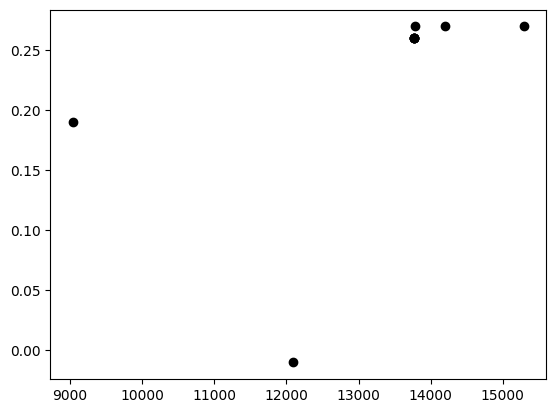

In [17]:
plt.figure()
plt.scatter(np.array(x_acq), np.array(y_acq), color="k")

In [18]:
RMSE_POI = rmse(y_pred=y_pred, test_data=test_data[:,2])
print(RMSE_POI)

0.1124839691929858


## Expected Improvement Acquisition Function

In [19]:
def Exp_Imp(y_pred, lower, upper, epsilon):
    EI = np.empty(y_pred.numpy().size,dtype=float)
    y_best = y_pred.numpy().max()
    sigma = (upper.numpy()[:,0] - lower.numpy()[:,0])/2
    for i in range(0,y_pred.numpy().size):
        if sigma[i] > 1e-4:
            zz = (y_pred[i]-y_best-epsilon)/sigma[i]
            EI[i] = (y_pred[i]-y_best-epsilon)*norm.cdf(zz,scale=1)+sigma[i]*norm.pdf(zz,scale=1)
        else:
            EI[i] = 0.0
    loc = EI.argmax()
    return EI, loc

### Reinitialize and Retrain Model

In [20]:
miniset = generate_initial_dataset(data=data, Ni = 10, set_seed=1)
X_train = torch.from_numpy(miniset[:,0:2])
Y_train = torch.from_numpy(miniset[:,2:3])
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=n_tasks)
model = BatchIndependentMultitaskGPModel(X_train, Y_train, likelihood)
model = train_model(model)
y_pred, lower, upper = model_predict(model, X_test)

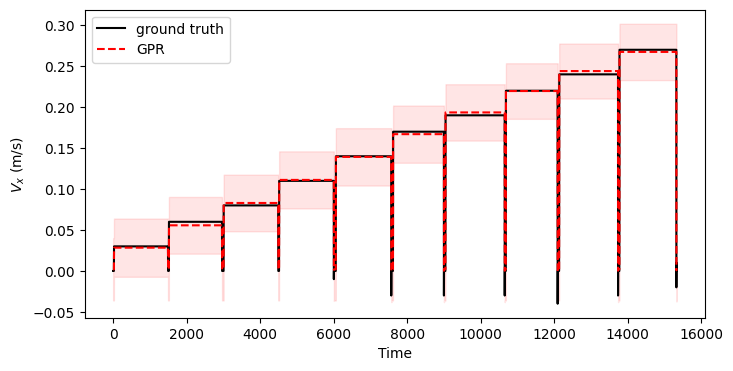

In [21]:
# set how many loops to train
n_loops = 10

x_train = miniset[:,0:2]
y_train = miniset[:,2:3]

x_plot = np.linspace(0, len(y_pred), len(y_pred))
x_acq = []
y_acq = []

for i in range(n_loops):

    expi, loc = Exp_Imp(y_pred = y_pred,lower = lower,upper = upper,epsilon = 1)
    
    x_new = X_test[loc,:].numpy().reshape((1,-1))
    y_new = Y_test[loc,:].numpy().reshape((1,-1))
    x_acq.append(x_plot[loc]) 
    y_acq.append(y_new[0,0])

    x_train = np.vstack((x_train, x_new))
    y_train = np.vstack((y_train, y_new))
    X_train = torch.from_numpy(x_train)
    Y_train = torch.from_numpy(y_train)

    # Retrain Model
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=n_tasks)
    model = BatchIndependentMultitaskGPModel(X_train, Y_train, likelihood)
    model = train_model(model)

    # Evaluate Model
    y_pred, lower, upper = model_predict(model, X_test)



plt.figure(figsize=(8,4))
plt.plot(test_data[:,2],label='ground truth',color='k')

plt.plot(y_pred.numpy(), color = 'red', label = 'GPR', linestyle = '--')
plt.fill_between(x_plot,lower.numpy()[:,0], upper.numpy()[:,0], alpha = 0.1, color = 'red')
plt.legend()
plt.xlabel('Time')
plt.ylabel('$V_x$ (m/s)')
plt.show()

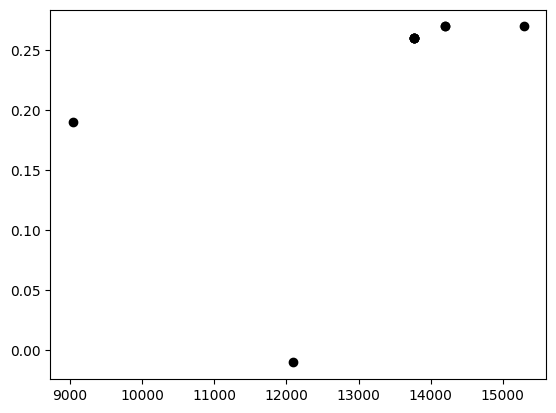

In [22]:
plt.figure()
plt.scatter(np.array(x_acq), np.array(y_acq), color="k")

In [23]:
RMSE_EI = rmse(y_pred=y_pred, test_data=test_data[:,2])
print(RMSE_EI)

0.1124839691929858


In [24]:
# import datetime

# t = tuple(map(int, c[0].split('_')))

# print(t)